In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
import seaborn as sns
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam




2025-02-16 18:44:57.250491: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-16 18:44:57.261153: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739731497.274591  114368 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739731497.278955  114368 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-16 18:44:57.292746: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
dir_dataset="Testing"
classes=os.listdir(dir_dataset)
print("Classes disponibles:",classes)

Classes disponibles: ['Late_Blight', 'Healthy', 'Early_Blight']


In [3]:
for class_name in classes:
    class_dir=os.path.join(dir_dataset, class_name)
    num_images=len(os.listdir(class_dir))
    print(f"Classe {class_name} : {num_images} images ")

Classe Late_Blight : 141 images 
Classe Healthy : 102 images 
Classe Early_Blight : 162 images 


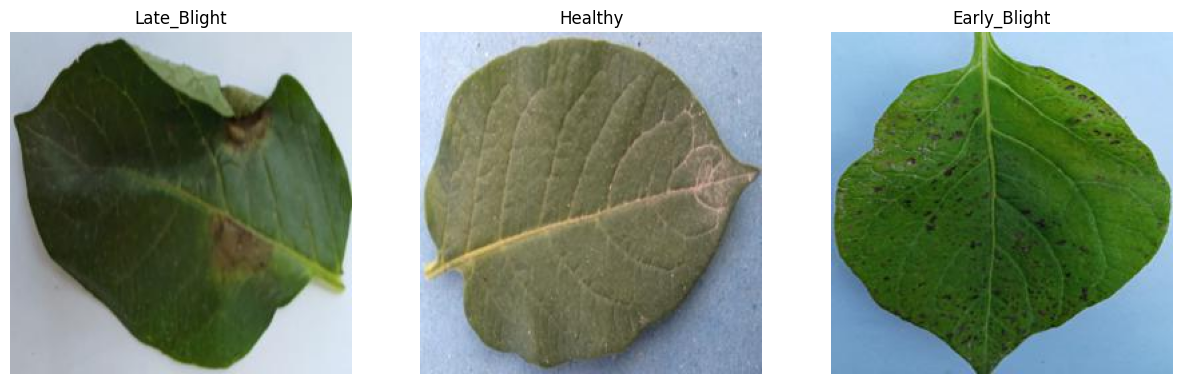

In [4]:
plt.figure(figsize=(15,10))
for i, class_name in enumerate(classes):
    class_dir = os.path.join(dir_dataset,class_name)
    img_name=os.listdir(class_dir)[0]
    img_path=os.path.join(class_dir, img_name)
    img=cv2.imread(img_path)
    img=cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)

    plt.subplot(1, len(classes), i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')

plt.show()

In [5]:
# Redimensionnement
def preprocess_image(image_path, target_size=(150, 150)):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir en RGB
    img = cv2.resize(img, target_size)  # Redimensionner
    img = img / 255.0  # Normaliser les pixels entre 0 et 1
    return img

In [6]:
images=[]
labels=[]

for class_idx, class_name in enumerate(classes):
    class_dir=os.path.join(dir_dataset, class_name)
    for img_name in os.listdir(class_dir):
        img_path=os.path.join(class_dir, img_name)
        img=preprocess_image(img_path)
        images.append(img)
        labels.append(class_idx) #Étiquette numérique pour chaque classe

images=np.array(images)
labels=np.array(labels)

In [7]:
label_binarizer = LabelBinarizer()
labels = label_binarizer.fit_transform(labels)

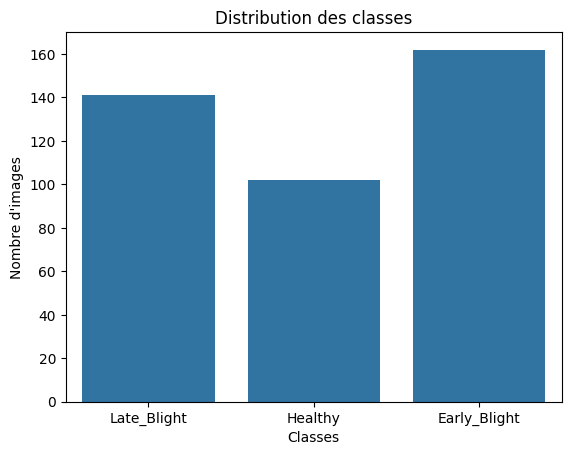

In [8]:
class_counts = np.sum(labels, axis=0)

sns.barplot(x=classes, y=class_counts)
plt.title("Distribution des classes")
plt.xlabel("Classes")
plt.ylabel("Nombre d'images")
plt.show()

In [9]:
print("Forme des images :", images.shape)
print("Valeurs des pixels (min, max) :", np.min(images), np.max(images))
print("Moyenne des pixels :", np.mean(images))
print("Écart_type des pixels :", np.std(images))

Forme des images : (405, 150, 150, 3)
Valeurs des pixels (min, max) : 0.0 1.0
Moyenne des pixels : 0.43563327312013084
Écart_type des pixels : 0.2625932744108634


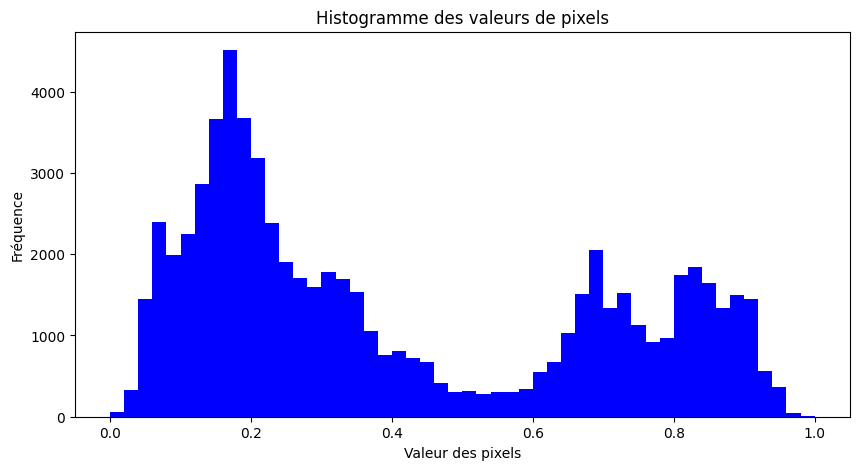

In [10]:
plt.figure(figsize=(10,5))
plt.hist(images[0].ravel(), bins=50, color='blue')
plt.hist(images[0].ravel(), bins=50, color='blue')
plt.title("Histogramme des valeurs de pixels")
plt.xlabel("Valeur des pixels")
plt.ylabel("Fréquence")
plt.show()

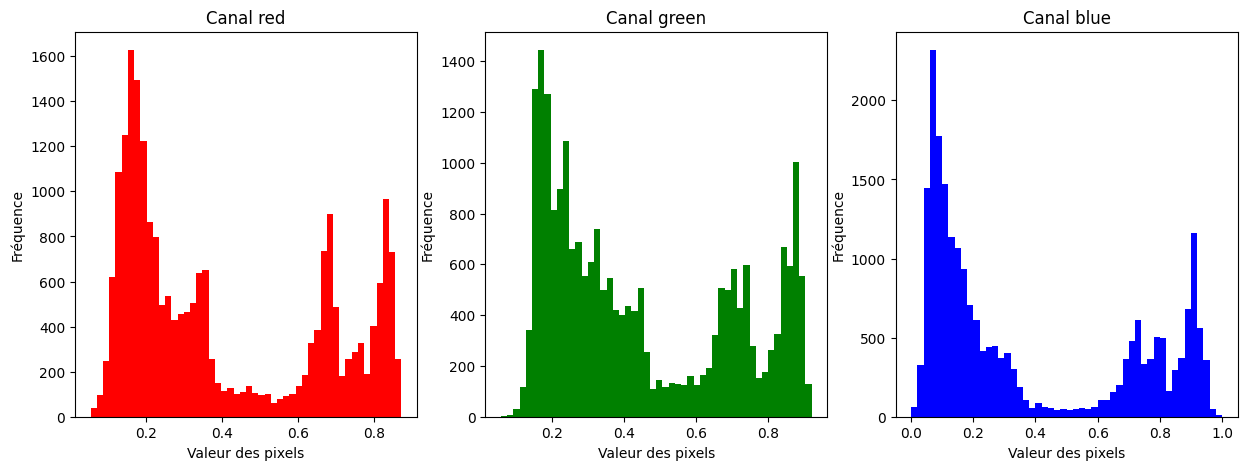

In [11]:
plt.figure(figsize=(15, 5))
for i, color in enumerate(['red', 'green', 'blue']):
    plt.subplot(1, 3, i+1)
    plt.hist(images[0][:, :, i].ravel(), bins=50, color=color.lower())
    plt.title(f"Canal {color}")
    plt.xlabel("Valeur des pixels")
    plt.ylabel("Fréquence")

plt.show()    

In [12]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print("Taille des ensembles :")
print(f"Entrainement :, {X_train.shape[0]} images")
print(f"Validation :{X_val.shape[0]} images")
print(f"Test : {X_test.shape[0]} images")



Taille des ensembles :
Entrainement :, 259 images
Validation :65 images
Test : 81 images


In [13]:
np.savez('potato_desease_data.npZ', X_train=X_train, X_val=X_val, X_test=X_test, y_train=y_train, y_val=y_val, y_test=y_test)

In [14]:
# Augmentation des données

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=(0.8, 1.2),
    fill_mode='nearest'
)

# Appliquer l'augmentation aux données d'entraînement
train_generator = train_datagen.flow(
    X_train, y_train,
    batch_size=32
)

# Prétraitement des données de validation (pas d'augmentation)
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=32
)

In [15]:


# Paramètres
IMG_SIZE = (150, 150)  # Taille des images

# Charger MobileNetV2 pré-entraîné (sans la couche fully connected)
base_model = MobileNetV2(
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),  # Taille des images en entrée
    include_top=False,  # Ne pas inclure la couche fully connected
    weights='imagenet'  # Utiliser les poids pré-entraînés sur ImageNet
)

# # Geler les couches du modèle de base (pas d'entraînement)
# base_model.trainable = False

# Dégeler les dernières couches de MobileNetV2
base_model.trainable = False


/tmp/ipykernel_114368/1083811078.py:5: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(
2025-02-16 18:45:00.829151: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [16]:
# Ajouter des couches personnalisées pour la classification
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Pooling pour réduire la dimension spatiale
    layers.Dense(128, activation='relu'),  # Couche fully connected
    layers.Dropout(0.5),  # Dropout pour éviter le surapprentissage
    layers.Dense(3, activation='softmax')  # Couche de sortie (3 classes)
])

In [17]:
# Afficher un résumé du modèle
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
model.compile(
    optimizer='adam',  # Optimiseur Adam
    loss='categorical_crossentropy',  # Fonction de perte pour la classification multi-classes
    metrics=['accuracy']  # Métrique : précision
)

In [19]:
epochs = 30  # Nombre d'époques
batch_size = 32  # Taille du batch

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),  # Arrêt précoce
    ModelCheckpoint('best_model_mobilenetv2.keras', save_best_only=True)  # Sauvegarde du meilleur modèle
]


In [20]:

history = model.fit(
    X_train, y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val)
)

Epoch 1/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 355ms/step - accuracy: 0.4301 - loss: 1.6661 - val_accuracy: 0.7692 - val_loss: 0.5280
Epoch 2/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.6685 - loss: 0.7273 - val_accuracy: 0.8462 - val_loss: 0.5503
Epoch 3/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 225ms/step - accuracy: 0.7624 - loss: 0.5537 - val_accuracy: 0.8000 - val_loss: 0.3950
Epoch 4/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 232ms/step - accuracy: 0.8381 - loss: 0.4003 - val_accuracy: 0.8769 - val_loss: 0.3801
Epoch 5/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 254ms/step - accuracy: 0.8852 - loss: 0.3336 - val_accuracy: 0.8615 - val_loss: 0.3242
Epoch 6/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 237ms/step - accuracy: 0.9308 - loss: 0.2465 - val_accuracy: 0.8923 - val_loss: 0.3264
Epoch 7/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 228ms/step - accuracy: 0.9376 - loss: 0.2050 - val_accuracy: 0.8923 - val_loss: 0.3363
Epoch 8/30
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 214ms/step - accuracy: 0.9121 - loss: 0.2333 - val_accuracy: 0.8462 - val_loss:

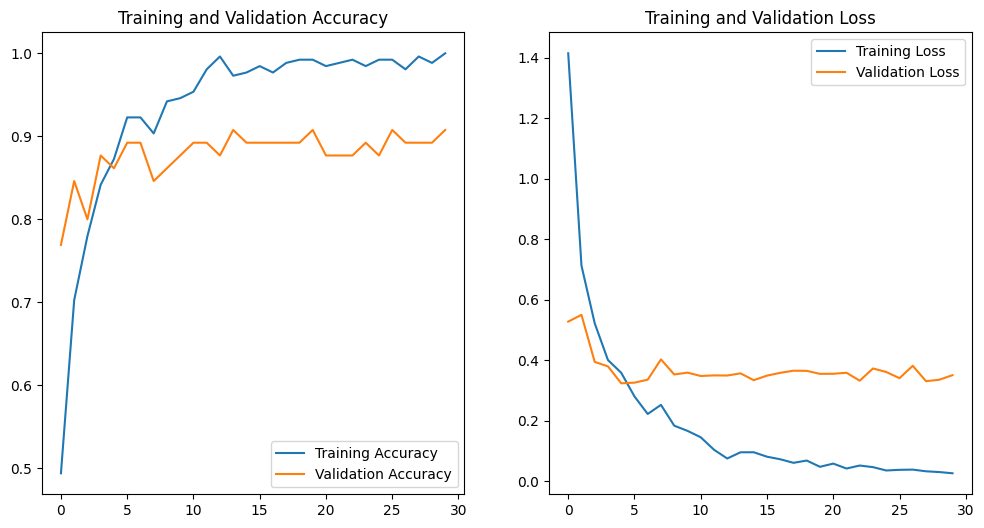

In [21]:
# Tracer la précision et la perte
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [22]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print(f"Précision sur les données de test : {test_acc:.2f}")
print(f"Perte sur les données de test : {test_loss:.2f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9177 - loss: 0.2123
Précision sur les données de test : 0.91
Perte sur les données de test : 0.25


In [23]:
# Charger une nouvelle image
new_image_path = 'Testing/Early_Blight/Early_Blight_156.jpg'
new_image = preprocess_image(new_image_path)

# Redimensionner l'image pour correspondre à l'entrée du modèle
new_image = np.expand_dims(new_image, axis=0)  # Ajouter une dimension pour le batch

# Faire une prédiction
predictions = model.predict(new_image)
predicted_class = np.argmax(predictions, axis=1)

# Afficher la prédiction
print(f"Classe prédite : {classes[predicted_class[0]]}")
print(f"Probabilités : {predictions}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 892ms/step
Classe prédite : Early_Blight
Probabilités : [[1.4026651e-06 2.3834482e-06 9.9999619e-01]]


In [24]:
model.save('potato_disease_model.h5')